# Tutorial: Using NiftyNet to Train U-Net for Brain Tumour Segmentation

In this tutorial, you'll learn how to use NiftyNet to implement the original 2D U-Net. This demo will take you through all the stages of a typical experiment, from data gathering through training, to analysing the results. 

## The problem: 

U-Net [[1](#refs)] is one of the (if not **_the_**) most popular neural net architecture in medical image computing. Its 2015 publication demonstrated a range of world-leading results on a variety of datasets. In this demonstration, we will show you how to use NiftyNet [[2](#refs)], an open-source platform for deep learning in medical image computing and computer assisted intervention, to train a U-Net. We also demonstrate how to test various configurations to compare different approaches (for example, which augmentation steps to use). 

In this demo, we will also use a residual network [[3](#refs)] to fit the same data. 

## Before we start:

If you want to run the experiments yourself, you will need to download the appropriate libraries. In addition to NiftyNet, you will need: `scikit-image` and `simpleitk`. These are both available as python packages (you can `pip install` them. 

In the terminal, go to the directory containing `niftynet`. You should see a `requirements-cpu` file. If you have access to a graphics card, use `requirements-gpu` instead. 

## TODO: 

* copy the directory and all subfolders to your machine
* pip install the relevant modules

`pip2 install --ignore-installed -r requirements-cpu.txt `

`pip2 install --ignore-installed seaborn simpleitk scikit-image`


## What's here: 

1. [Setup](#setup)
2. [The data](#data)
3. [The architecture](#arch)
4. [The loss function](#loss)
5. [Visualising the Data](#vis)
6. [Data Augmentation](#aug)
7. [Configuration Files](#conf)
8. [Picking Augmentation Parameters: Visualisation](#datavis)
8. [The Experiments](#exp)
9. [Results](#results)
10. [Monitoring Training Progress](#tb)
11. [Analysing Results and Wrapping Up](#analysis)
11. [References](#refs)

<a id="setup"></a> 
## The setup:
To do these experiments, we need to look at: 
<a id="data"></a>

## The data: 
The BRaTS dataset has been a popular competition in medical image computing. The data is of brain scans of four modalities and a hand-drawn label, detailing which pixels are tumour. In this demo, we'll be using 2-d slices of the 3-d scans to make it computationally viable. 

<a id="arch"></a>
## The architecture: 

In terms of implementing the specific u-net architecture, we're in luck! NiftyNet has the 2-d unet implemented already. It's located at `niftynet.networks.unet_2d`, which you can find by searching the term `"unet"` at the [documentation page](http://niftynet.readthedocs.io/en/dev/) of NiftyNet. We will also use `highres3dnet`, which (counter to the name) can also be used on 2-d images. 

<a id="loss"></a>
## The loss function: 

There are many available loss functions: we will look at two. The cross-entropy is an information-theoretic measure that works best for balanced datasets. The Dice score is a different measure that accounts for class imbalance. 

We'll have a look at some of the data here: 


<a id="vis"></a>
## Visualising the data

It is always useful to have some idea of what the data looks like. Here, we look at the data for one subject. Feel free to change 'ASO' below and look at some of the others as well. 

In [18]:
import os 
import nibabel as nib 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.io import imread
import re
import seaborn as sns 

%matplotlib inline

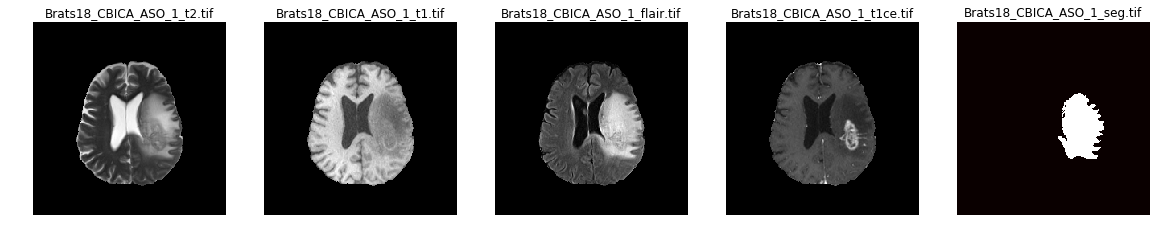

In [19]:
brats_dir = "./brats_2d/"

f, axes = plt.subplots(1, 5, figsize=(20,8))

# here, we look at a specific subject (the only one with 'ASO' in its name)
for i, tif in enumerate([x for x in os.listdir(brats_dir) if x.endswith('tif') and 'ASO' in x]):
    img = imread(os.path.join(brats_dir, tif))
    axes[i].imshow(np.rot90(img, 3), cmap='gray') # want image in 'vertical' arrangement
    axes[i].set_title(tif)
    if 'seg' in tif:
        axes[i].imshow(np.rot90(img, 3), cmap='hot')
    axes[i].set_axis_off()
    
    

<a id="aug"></a>

## Data augmentation: 

To traing a network and have its performance generalise well to previously-unseen data, it is important to add some image augmentation. In U-Net, the authors use augmentation via non-linear deformation. Searching the [documentation page](http://niftynet.readthedocs.io/en/dev/)  for deformation, I can see that there is an implementation of elastic deformation in `niftynet.layer.rand_elastic_deform module`. We can use this augmentation to create variety in our training set, which should improve generalisation to unseen data. We can also use left-right flipping. 

**Other things:** It can be useful to track the performance on a validation set during training. To do this, NiftyNet uses a `dataset_split` csv file which allows the data to be labelled as training, validation or evaluation. 

<a id="conf"></a>
## The config file: 

To set all the options, we will use a configuration file. This will include file paths, which network to use, and other options. 

There is guidance on config files available [here](https://github.com/NifTK/NiftyNet/tree/dev/config). 

We will base our configuration files on the `config/default_segmentation.ini` file in the repository. 

Here, we go through it step-by-step: 

## Data: 

Here, I show what I've changed from the default example. 

```diff
############################ input configuration sections
-[modality1]
+[t1]   # you can name this whatever you want
-csv_file=  # we will find the images by searching
-path_to_search = ./data/monomodal_parcellation
+path_to_search = ./brats_2d
-filename_contains = T1
+filename_contains = _t1
-filename_not_contains =
+filename_not_contains = t1ce # we don't want confusion between modalities
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (256, 256, 1)  # this window size will take in basically the whole image
interp_order = 3
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage  # use this for loading 2-d images 

+[t1ce]   # you can name this whatever you want
+path_to_search = ./user/brats_2d
+filename_contains = _t1ce
+filename_not_contains = 
+spatial_window_size = (256, 256, 1)
+interp_order = 3
+loader = skimage  # use this for loading 2-d images 

+[flair]   # you can name this whatever you want
+path_to_search = ./user/brats_2d
+filename_contains = _flair
+filename_not_contains = 
+spatial_window_size = (256, 256, 1)
+interp_order = 3
+loader = skimage  # use this for loading 2-d images 

+[t2]   # you can name this whatever you want
+path_to_search = ./user/brats_2d
+filename_contains = _t2
+filename_not_contains = 
+spatial_window_size = (256, 256, 1)
+interp_order = 3
+loader = skimage  # use this for loading 2-d images 


[label]
-path_to_search = ./example_volumes/monomodal_parcellation
+path_to_search = ./user/brats_2d
-filename_contains = Label
+filename_contains = _seg
filename_not_contains =
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (84, 84, 1)
interp_order = 0  # we want integer labels to be used 
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage


```

I've taken out the bits that look relevant, and also made sure to load each of the modalities together. 

The differences: we need to use a loader other than nibabel (I chose skimage, although there are other options). This is to avoid converting the images to nifti before training. 

## System Parameters 
```diff
[SYSTEM]
cuda_devices = -1
-num_threads = 2
+num_threads = 6
num_gpus = 0
+model_dir = ./models/unet
```
For the `SYSTEM` parameters, I increased the number of threads (start low for this and test as you increase it: it can freeze your computer if you're not careful). The `model_dir` will control where all the results are saved, so it's important to double check this and not over-write old experiments. 


## Network 

```diff
[NETWORK]
-name = toynet
+name = unet_2d 
-activation_function = prelu
+activation_function = relu 
+; having a bigger batch size will let us train quicker. 
batch_size = 5
- decay = 0.1
- reg_type = L2

# volume level preprocessing
-volume_padding_size = 21
+volume_padding_size = (92, 92, 0)

-# histogram normalisation
-histogram_ref_file = ./example_volumes/monomodal_parcellation/standardisation_models.txt
+histogram_ref_file = ./hist.txt
norm_type = percentile
cutoff = (0.01, 0.99)
-normalisation = False
+normalisation = True
-whitening = False
+whitening = True
normalise_foreground_only=True
foreground_type = otsu_plus
multimod_foreground_type = and

queue_length = 10
```

I have told the network to use U-Net, and also changed the default normalisation options. I do not want 'foreground' normalisation, as our images take up the whole field of view of the image file. I need the volume padding, because U-Net wouldn't produce segmentation results for voxels near the border otherwise. 


## Training

```diff
[TRAINING]
-sample_per_volume = 32
+sample_per_volume = 2
-rotation_angle = (-10.0, 10.0)
-scaling_percentage = (-10.0, 10.0)
-random_flipping_axes= 1
+random_flipping_axes= 0
-lr = 0.01
+lr = 0.0001
+loss_type = CrossEntropy
starting_iter = 0
save_every_n = 100
-max_iter = 10
+max_iter = 200
max_checkpoints = 20

+do_elastic_deformation = True
+deformation_sigma = 15
+num_ctrl_points = 6
+proportion_to_deform=0.5

+validation_every_n = 10
+validation_max_iter = 1

```

The major things I have changed here relate are the loss function and the augmentation. I use the cross-entropy, as per the original paper. I also add some instructions for the elastic deformation. Finally, I add an instruction for validation to occur every ten iterations. For the specific deformation parameters, I have determined these by independent experimentation (not shown here). 

<a id="datavis"></a>

## Visualising the effects of pre-processing: 

Here, we are giong to visualise the effects of data augmentation (specifically the random elastic deformation) to get some idea of what we should set the parameters to. I'm building this visualisation from the tools in `demos/module_examples`, where it shows how to visualise the effects of the pre-processing. 

Step 1: build a minimal pipeline to see the effects of the augmentation. I will need normalisation (and I remember I used the `whitening` flag. I will need some padding. Finally, I will add a `RandomElasticDeformationLayer`. I will visualise the results of this augmentation and choose a value that seems appropriate. Were the problem one we wanted to heavily optimise, it may be worth cross-validating over parameter choices. Here, however, we just want something that looks reasonable. 

In [20]:
import sys
niftynet_path = './NiftyNet_GIT'
sys.path.append(niftynet_path)


from niftynet.io.image_reader import ImageReader
# from niftynet.contrib.dataset_sampler.sampler_uniform_v2 import UniformSampler
from niftynet.layer.pad import PadLayer
from niftynet.layer.rand_elastic_deform import RandomElasticDeformationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer
from niftynet.layer.rand_flip import RandomFlipLayer


def create_image_reader(num_controlpoints, std_deformation_sigma):
    # creating an image reader.
    data_param = \
        {'t1ce': {'path_to_search': 'brats_2d/', 
                'filename_contains': ('654', '_t1ce'),
                'loader': 'skimage'},
         'label': {'path_to_search': 'brats_2d/', 
                'filename_contains': ('654', '_seg'),
                'loader': 'skimage',
                'interp_order' : 0}
        }
    reader = ImageReader().initialise(data_param)
    reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 't1ce'))
    reader.add_preprocessing_layers(PadLayer(
                     image_name=['t1ce', 'label'],
                     border=(20,20,0),
                     mode='constant')) 

    reader.add_preprocessing_layers(RandomElasticDeformationLayer(
                     num_controlpoints=num_controlpoints,
                     std_deformation_sigma=std_deformation_sigma,
                     proportion_to_augment=1,
                     spatial_rank=2)) 
    
    reader.add_preprocessing_layers(RandomFlipLayer(
                 flip_axes=(0,))) 

    return reader



AttributeError: module 'tensorflow' has no attribute 'logging'

In [ ]:
f, axes = plt.subplots(5,4,figsize=(15,15))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes):
    std_sigma = 5 * (i+1)
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(0)
        ax.imshow(image_data['t1ce'].squeeze(), cmap='gray')
        ax.imshow(image_data['label'].squeeze(), cmap='jet', alpha=0.2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)


To my eyes, 10 seems about the right number: some significant deformation (images look quite different) but without much in the way of distorting the brain beyond recognisability (like in $\sigma=25$).

## Inference

```diff
[INFERENCE]
-border = (0, 0, 1)
+border = (92, 92, 0)  # please note the zero-entry in the last dimension. 
-#inference_iter = 10
+# use last available checkpoint for inference
+inference_iter = -1 
-save_seg_dir = ./output/toy
+# note, this is relative to the model_dir
+save_seg_dir = ./output
output_interp_order = 0
-spatial_window_size = (0, 0, 3)
+spatial_window_size = (256, 256, 1)
```

These changes all relate to the specific requirements of 2-d U-Net.


## Finishing the config file: 

We just have to tell the network the final details. 

```diff
[SEGMENTATION]
-image = modality1
+image = t1, t1ce, flair, t2
label = label
output_prob = False
-num_classes = 160
+num_classes = 2
label_normalisation = False

```

`label normalisation` is unnecessary, as we have labels that are binary to begin with. Apart from that, this is a case of telling the `segmentation` application how to use the data we've specified. 

# Running the training:

To start training, here are the commands for two different networks: to train, I did this: 

`python NiftyNet_GIT/net_segment.py train -c ./unet_brats.ini --max_iter 50 --dataset_split_file ./brats_splits.csv`

or: 

`python NiftyNet_GIT/net_segment.py train -c ./hr_brats.ini --max_iter 50 --dataset_split_file ./brats_splits.csv`


I left it training for only about 20 iterations (way too short) before I got bored and pressed `ctrl+c`, which saved the latest model. I also did this because I could see the training loss had decreased by a lot, and I wanted to see some outputs. Then I repeated the niftynet training command, switching 'train' for 'inference'. I then loaded in the output with nibabel to compare with the ground truth. Note: this command only does the subjects labelled `inference` in the `dataset_split` file. We also have specified the `dataset_split_file` to make sure we always have the same training/validation/inference sets to make it a fairer test. 

`python NiftyNet_GIT/net_segment.py inference -c ./unet_brats.ini --dataset_split_file .brats_splits.csv`

and 

`python NiftyNet_GIT/net_segment.py inference -c ./hr_brats.ini --dataset_split_file ./brats_splits.csv`

In [ ]:
!net_segment train -c ./hr_brats.ini --max_iter 50 --dataset_split_file ./brats_splits.csv

In [ ]:
!python3 NiftyNet_GIT/net_segment.py inference -c ./unet_brats.ini --dataset_split_file .brats_splits.csv

## Evaluation: 

The Dice score is a commmonly-used similarity metric in medical imaging. Here, I define it and calculate it. 

In [ ]:
def dice_score(gt, est): 
    gt, est = [x.ravel().astype(np.float32) for x in (gt, est)]
    return np.sum(2 * (gt * est) / np.sum(gt **2 + est ** 2))


<a id="exp"></a>
# The Experiments: 

Although there are many experiments you could do, I will recommend a simple one: 

Which augmentation methods lead to the best performance of the segmentation tool? 

To do this, you could vary the augmentation to do: 

1. no augmentation (baseline) 
2. random flips 
3. elastic deformation 
4. flips + deformation 

You should do this by writing command-line arguments, making sure to change the `model_dir`. Note that any arguments on the command-line will override any options given in the `.ini` file, so you can change them here. 


## Commands for the command line: 

By running the file, I show here an example of the command line commands I will use. 

```
python NiftyNet_GIT/net_segment.py train -c ./unet_brats.ini --do_elastic_deformation True --random_flipping_axes '0' --model_dir ./models/unet_def_and_flip --dataset_split_file ./brats_splits.csv

python NiftyNet_GIT/net_segment.py train -c ./unet_brats.ini --do_elastic_deformation True --random_flipping_axes -1 --model_dir ./models/unet_def_only --dataset_split_file ./brats_splits.csv

python NiftyNet_GIT/net_segment.py train -c ./unet_brats.ini --do_elastic_deformation False --random_flipping_axes '0' --model_dir ./models/unet_flip --dataset_split_file ./brats_splits.csv

python NiftyNet_GIT/net_segment.py train -c ./unet_brats.ini --do_elastic_deformation False --random_flipping_axes -1 --model_dir ./models/unet_nodef --dataset_split_file ./brats_splits.csv`
```

You can do similar things to test the `highresnet` (making sure to change the ini file). 


In [ ]:
# n_plots lets you limit the number of plotted outputs
def plot_all_ests(out_dir, n_plots=3, exp_name = ''):     
    file_names = [f for f in os.listdir(out_dir) if f.endswith('.gz')]
    # make alphabetical
    file_names.sort()
    for graph_counter, fn in enumerate(file_names):
        subj_id = fn.rstrip('niftynet_out.nii.gz')

        gt = imread("./brats_2d/" + subj_id + "_seg.tif")
        out_pred = nib.load( out_dir + subj_id + "_niftynet_out.nii.gz").get_data() 

        f, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(np.rot90(gt, 3))
        axes[0].set_title('GT')
        axes[1].imshow(np.rot90(out_pred.squeeze(), 3))
        axes[1].set_title('%s estimate' % exp_name)

        ds = dice_score(gt, out_pred)

        axes[2].imshow(np.rot90((out_pred.squeeze()) != (gt), 3))
        axes[2].set_title('Difference im: Dice={:.3f}'.format(ds))

        for ax in axes:
            ax.set_axis_off()

        if graph_counter >= n_plots - 1:
            break
            
out_dir = "./models/unet/output/"
plot_all_ests(out_dir, exp_name='UNET', n_plots = 10 )

In [ ]:
plot_all_ests('./models/HR/output/', exp_name = 'HR', n_plots = 5 )

<a id="tb"></a>

## Monitoring during training

NiftyNet, by default, tracks training progress. To see this, use a command like: `tensorboard --logdir models`. 

I used this to choose a minimal point for the `Validation` curve to do the inference. 
The commands for inference are similar to aboce, except `train` is replaced by `inference` and I set the `--inference_iter` parameter depending on the training curves.

<a id="analysis"></a>

### Analysing the results: 

Above, I have provided a graphing function for the two methods and a function to get the data into a table. You should be able to use/extend these to investigate the results! 


In [ ]:
def get_results_table(exp_dict):
    """
    input: exp_dict: key is name of experiment. Value is location of output directory
    
    returns: dataframe of the results from the directories
    """

    results = {'subj_id': [], 'dice_score': [], 'experiment': []}
    for exp in exp_dict: 
        # making lists to hold the results
        out_dir = exp_dict[exp]
        
        # look at the nifti files in the directory 
        for fn in [f for f in os.listdir(out_dir) if f.endswith('.gz')]:

            subj_id = fn.rstrip('niftynet_out.nii.gz')

            gt = imread("./brats_2d/" + subj_id + "_seg.tif")
            out_pred = nib.load( out_dir + subj_id + "_niftynet_out.nii.gz").get_data() 

            results['subj_id'].append(subj_id)
            results['dice_score'].append(dice_score(gt, out_pred))
            results['experiment'].append(exp)
    
    return pd.DataFrame(results)



In [ ]:
exp_dict = {
    'unet': './models/unet/output/',
    'hrnet': './models/hr/output/'
}
df = get_results_table(exp_dict)
sns.boxplot(data=df, y='dice_score', x='experiment')

### Extension questions: 

Which models have bigger file size? Why? 
Which is quicker to train? 
Which gets better results? 

### Wrapping up: 

We have gone through how to do an experimental pipeline in NiftyNet, based on the experiments in the U-Net paper. While we have produced a lot of data and done a lot of work, the key components in the experiments were determined in the `config` files. By using command-line arguments to NiftyNet, we geenerated several experimental conditions. Finally, we generated and analysed the resulting data. 

<a id="refs"></a>
### References

[1] Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[2] Gibson, E., Li, W., Sudre, C., Fidon, L., Shakir, D., Wang, G., Eaton-Rosen, Z., Gray, R., Doel, T., Hu, Y. and Whyntie, T., 2017. NiftyNet: a deep-learning platform for medical imaging. arXiv preprint arXiv:1709.03485.

[3] Li, W., Wang, G., Fidon, L., Ourselin, S., Cardoso, M. J., & Vercauteren, T. (2017, June). On the compactness, efficiency, and representation of 3D convolutional networks: brain parcellation as a pretext task. In International Conference on Information Processing in Medical Imaging (pp. 348-360). Springer, Cham.
